In [84]:
#Importing the required modules
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
!pip install ts2vg

In [86]:
!pip install igraph

In [87]:
!pip install pycairo
!pip install cairocffi

  Using cached pycairo-1.21.0.tar.gz (340 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for pycairo
Failed to build pycairo
ERROR: Could not build wheels for pycairo which use PEP 517 and cannot be installed directly


In [88]:
from ts2vg import NaturalVG
from ts2vg import HorizontalVG
import numpy as np
import numpy

In [89]:
!pip install tabulate

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0]) 

In [97]:
#Output data frame format
column = ['Subject','Accelerometer Axis','Signal Length','Dimension','Delay','Permutation Entropy','Complexity','Activity','Position']
df_task2 = pd.DataFrame(columns=column)

In [94]:
#creating path to the folder
folder_path = r'/content/drive/MyDrive/FDA/PROJECT-2'
os.chdir(folder_path)
folders=os.listdir()

In [99]:
for folder in folders:
    files=[]
    files.extend(os.listdir(folder))
    for file in files:
        df = pd.read_csv(folder_path+'//'+folder+'//'+file)
        for ax in ['attr_x','attr_y','attr_z']:
            for i in np.array([3,4,5,6]): ##embedded dim
                for j in np.array([1,2,3]): ##embedded delay 
                    for k in np.array([1024, 2048, 4096]): ##signal length
                        
                        file_len = len(file.split('_'))
                        if file_len == 4:
                          Subject=(re.split(r"_",file)[-1].split('.')[0])
                          Activity=(re.split(r"_",file)[1])
                          Position=(re.split(r"_",file)[2])
                            
                        elif file_len > 4:
                          Subject=(re.split(r"_",file)[-2].split('.')[0]) # using regex to find the subject
                          Activity=(re.split(r"_",file)[1]) #using regex to find activity
                          Position=(re.split(r"_",file)[2]) #using regex to find position 
                            
                        df_task2 = df_task2.append({'Subject': Subject, 'Accelerometer Axis': ax , 'Signal Length': k,
                                     'Dimension' : i, 'Delay':j, 
                                     'Permutation Entropy': p_entropy(ordinal_patterns(df[ax][1000:1000+k], i, j)), 
                                     'Complexity': complexity(ordinal_patterns(df[ax][1000:1000+k], i, j)), 
                                      'Activity': Activity, 'Position' : Position}, ignore_index = True)

df_task2

(54324, 9)


,Subject,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity,Position
0,1,attr_x,1024,3,1,0.838868,0.131505,climbingdown,head
1,1,attr_x,2048,3,1,0.843104,0.128547,climbingdown,head
2,1,attr_x,4096,3,1,0.849263,0.124218,climbingdown,head
3,1,attr_x,1024,3,2,0.939547,0.055314,climbingdown,head
4,1,attr_x,2048,3,2,0.942292,0.052481,climbingdown,head
...,...,...,...,...,...,...,...,...,...
54319,14,attr_z,2048,6,2,0.788996,0.277317,climbingup,head
54320,14,attr_z,4096,6,2,0.759151,0.311738,climbingup,head
54321,14,attr_z,1024,6,3,0.894128,0.171316,climbingup,head
54322,14,attr_z,2048,6,3,0.868425,0.215969,climbingup,head


In [102]:
# Scatter Plots for walking and running with signal length 4096 and delay 1:
walk_run = df_task2[(df_task2['Activity']=='running') | (df_task2['Activity']=='walking')]
walk_run_signal_delay = walk_run[(walk_run['Signal Length']==4096) & (walk_run['Delay']==1)]

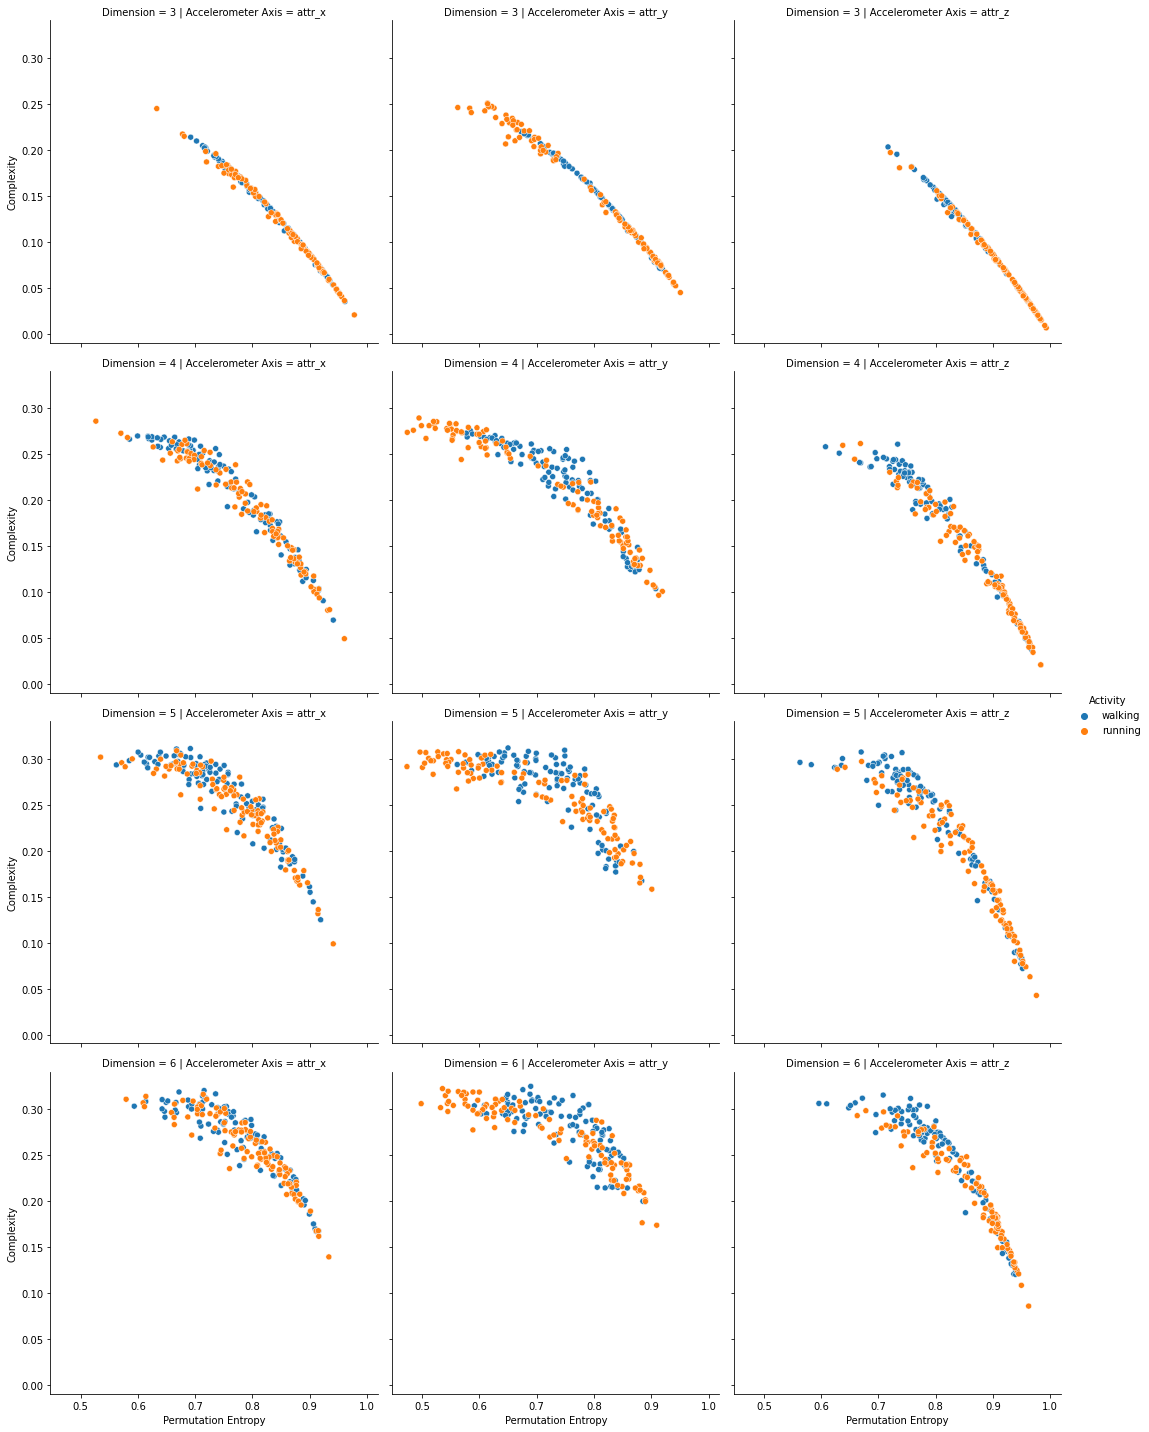

In [103]:
sns.relplot(data=walk_run_signal_delay,x='Permutation Entropy',y='Complexity',hue='Activity',col='Accelerometer Axis',row='Dimension')
plt.show()

In [106]:
# Scatter Plots for climbing up and climbing down with signal length 4096 and delay 1:
up_down = df_task2[(df_task2['Activity']=='climbingdown') | (df_task2['Activity']=='climbingup')]
up_down_signal_delay = up_down[(up_down['Signal Length']==4096) & (up_down['Delay']==1)]

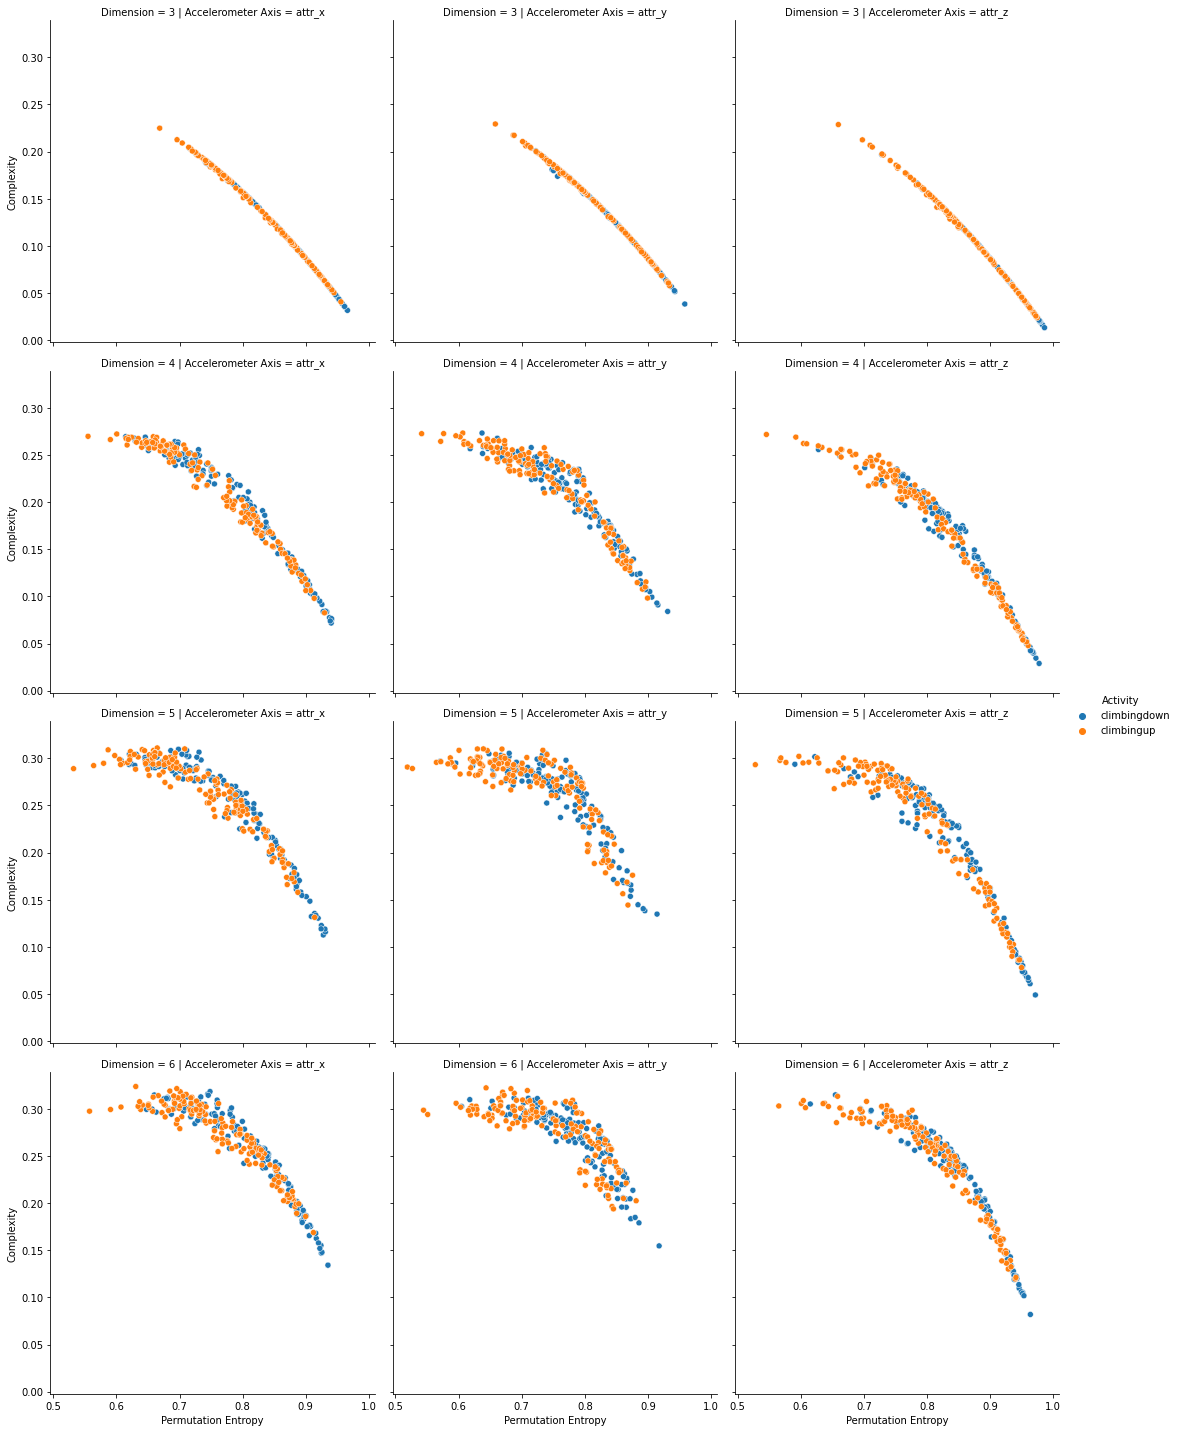

In [107]:
sns.relplot(data=up_down_signal_delay,x='Permutation Entropy',y='Complexity',hue='Activity',col='Accelerometer Axis',row='Dimension')
plt.show()